In [26]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings


In [27]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [28]:
DATASET_NAME = 'cstr'
WINDOW_SIZE = 5

In [82]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False, window_size=WINDOW_SIZE, noise_scale=0.1, use_classes=list(range(0,10)))

In [83]:
# print(timeseries.head)
# print(labels.head)
# print(test_timeseries.head)
# print(labels['label'])

In [84]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100))
], verbose=True)

In [111]:
c = RandomForestClassifier()
print(help(c))

Help on RandomForestClassifier in module sklearn.ensemble._forest object:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  Trees in the forest use the best split strategy, i.e. equivalent to passing
 |  `splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
 |  The sub-sample size is controlled with the `max_samples` paramet

In [85]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s


/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


[Pipeline] .......... (step 2 of 5) Processing features, total=   4.4s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s
[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.1s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:472: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/utils/_array_api.py:489: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier())],
         verbose=True)

In [109]:
test_timeseries

Caf         h          Qf        Ca           T     Tf  \
node_id   timestamp                                                           
node_1_10 6          1.0  6.007072  100.076250  0.035755  402.919840  320.0   
          7          1.0  5.994931   99.795221  0.036708  402.012553  320.0   
          8          1.0  6.002573  100.210016  0.037497  401.895636  320.0   
          9          1.0  6.001004   99.784286  0.037428  402.090838  320.0   
          10         1.0  6.003304  100.387886  0.037306  402.790851  320.0   
...                  ...       ...         ...       ...         ...    ...   
node_9_99 95         1.0  5.999950  100.000000  0.052742  395.721724  320.0   
          96         1.0  5.999950  100.000000  0.052755  395.720137  320.0   
          97         1.0  5.999950  100.000000  0.052765  395.716692  320.0   
          98         1.0  5.999950  100.000000  0.052779  395.711324  320.0   
          99         1.0  5.999950  100.000000  0.052754  395.718376  320.0   

                             Tc     Qc    Tcf           Q  
node_id   timestamp                                        
node_1_10 6          345.586638  15.00  300.0   99.994917  
          7          345.386882  15.00  300.0  100.072975  
          8          345.544503  15.00  300.0  100.017951  
          9          345.442948  15.00  300.0   99.938563  
          10         345.463963  15.00  300.0  100.025090  
...                         ...    ...    ...         ...  
node_9_99 95         337.186644  18.85  300.0  100.000000  
          96         337.185490  18.85  300.0  100.000000  
          97         337.186407  18.85  300.0  100.000000  
          98         337.188655  18.85  300.0  100.000000  
          99         337.186942  18.85  300.0  100.000000  

[4275 rows x 10 columns]

In [86]:
preds = pipeline.predict(test_timeseries)

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


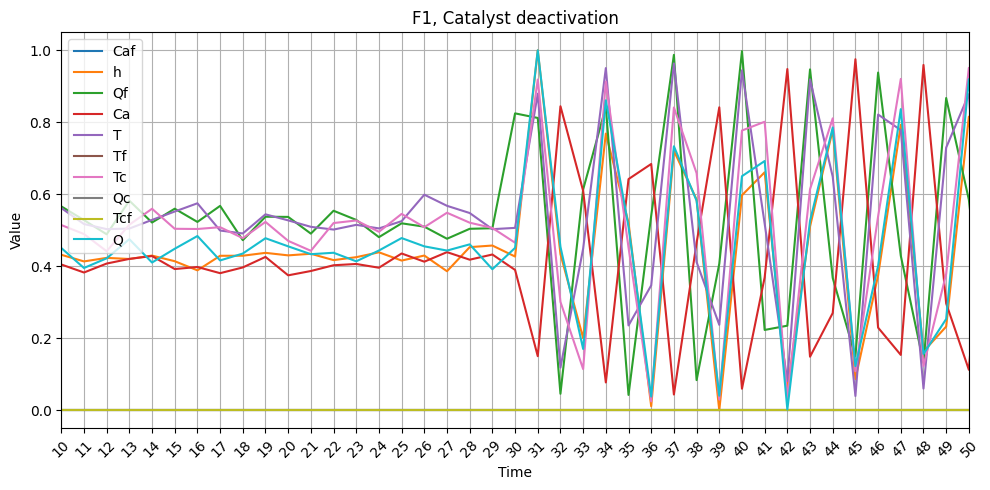

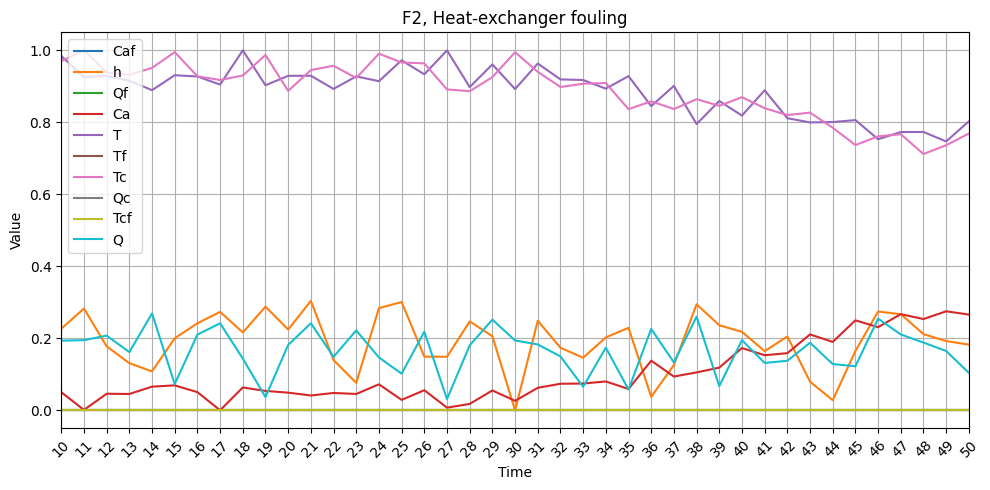

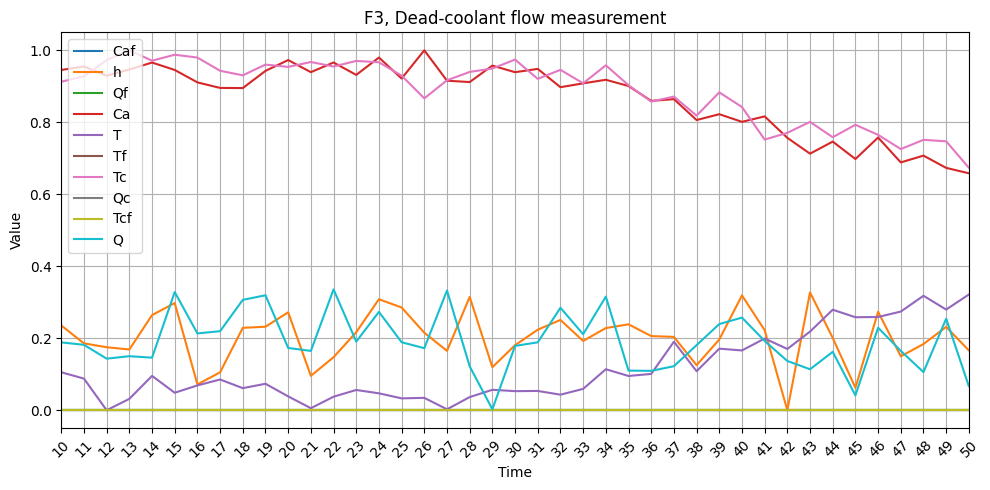

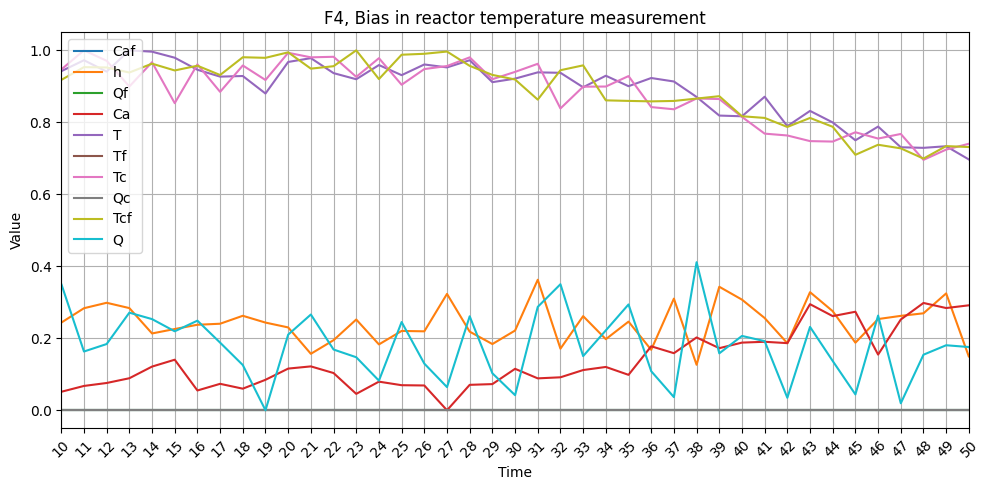

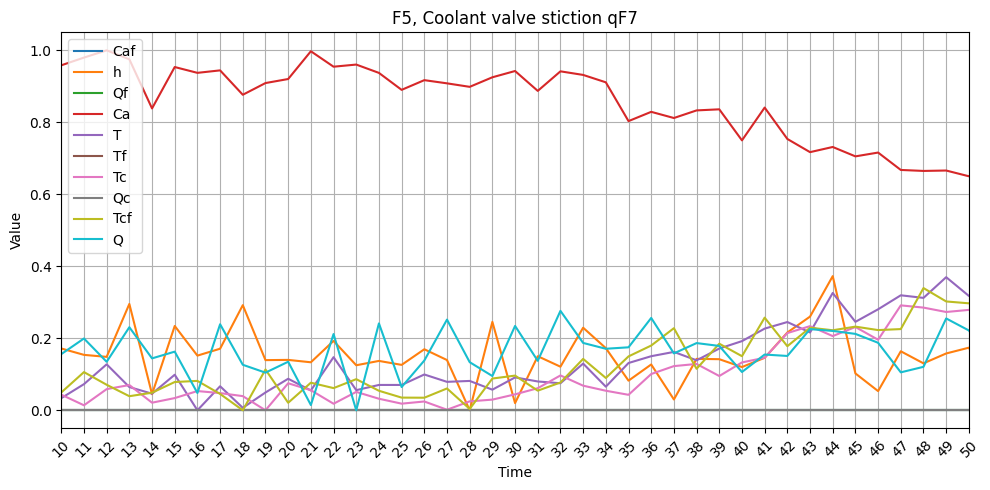

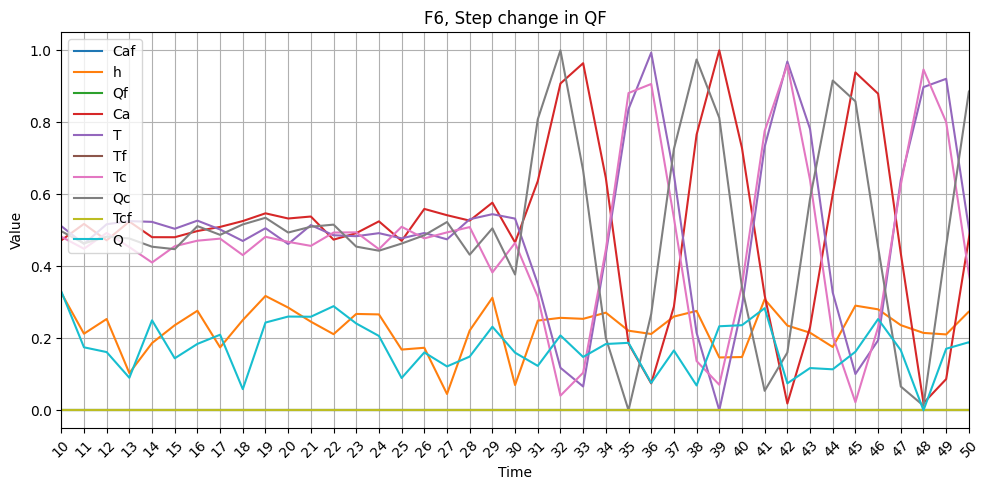

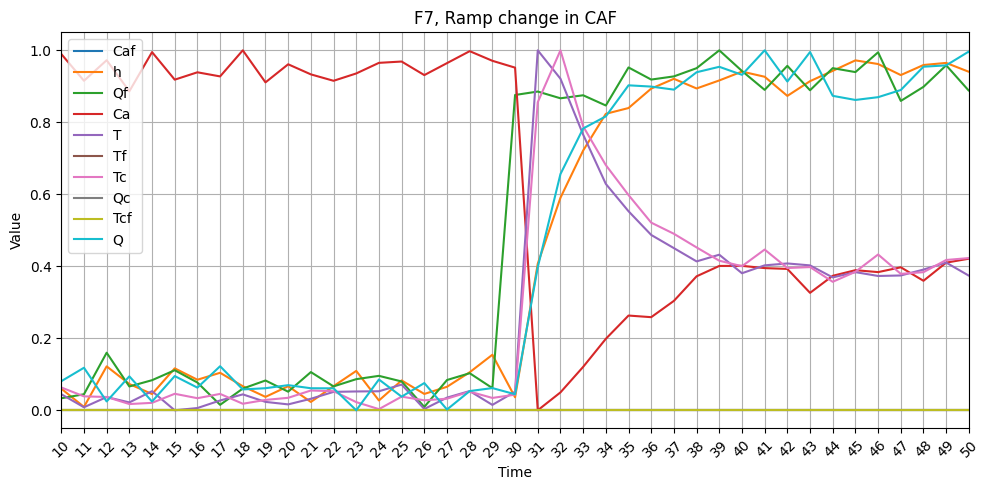

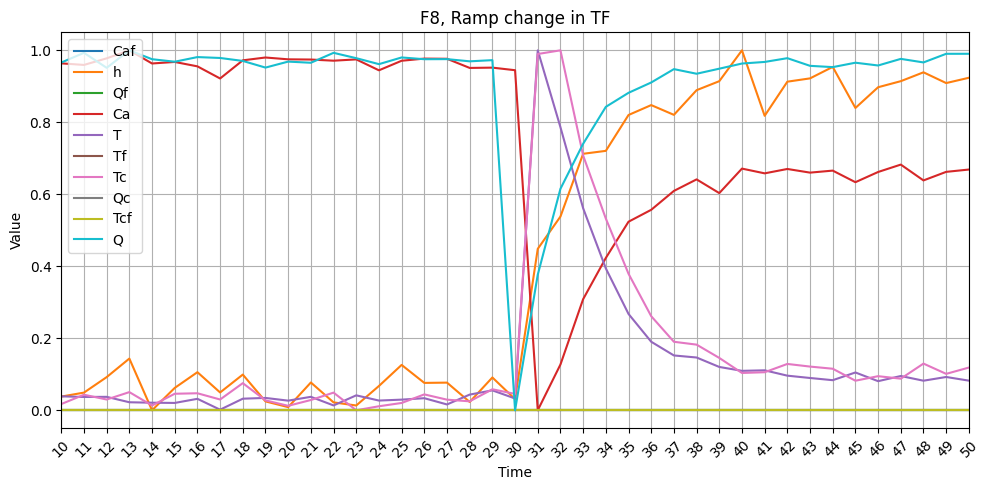

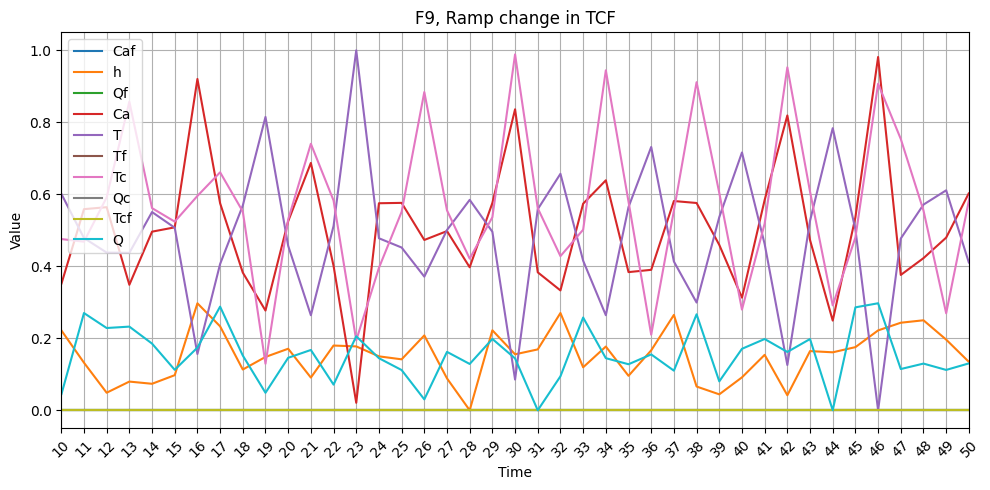

In [101]:
comparison_df=pd.DataFrame(test_timeseries)
comparison_df = comparison_df.groupby(level='node_id').last()
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

for i in range(1,10):
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()
    
    single_node_df_filtered = single_node_df

    # columns_to_plot = ['Tcf']
    # single_node_df_filtered = single_node_df[columns_to_plot]    

    scaler = MinMaxScaler()
    single_node_df_filtered = pd.DataFrame(scaler.fit_transform(single_node_df_filtered), columns=single_node_df_filtered.columns, index=single_node_df_filtered.index)    
    
    # print(single_node_df_filtered)

    single_node_df_filtered.plot(figsize=(10, 5))
    
    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(100,200))
    # plt.yticks(np.arange(0, 500, step=10))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df_filtered), step=1), rotation=45)
    plt.xlim(single_node_df_filtered.index[5], single_node_df_filtered.index[45])
    plt.tight_layout()
    plt.show()


In [102]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.7441004733606743
0 0.73125
1 0.9927007299270073
2 0.0
3 0.9302325581395349
4 0.9384615384615385
5 0.9384615384615385
6 0.9701492537313433
7 0.9927007299270073
8 0.9777777777777777
9 0.0


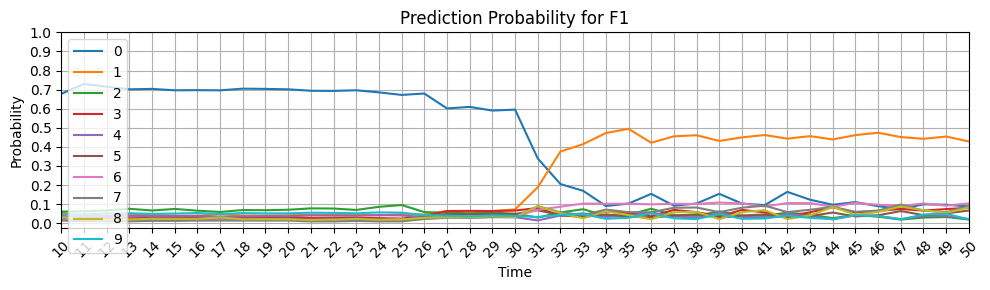

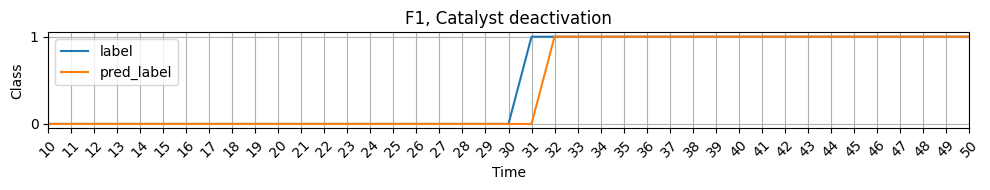

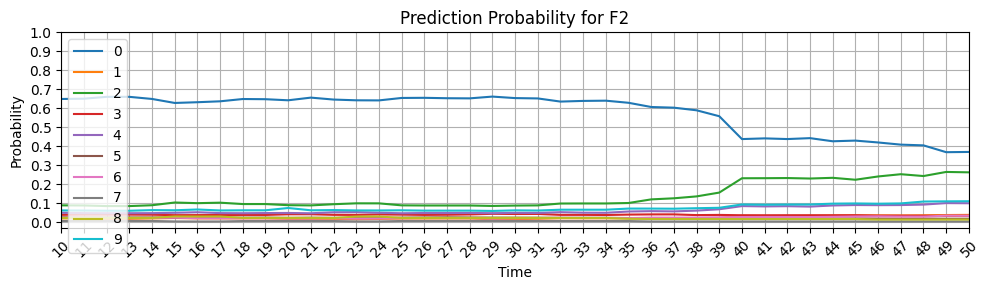

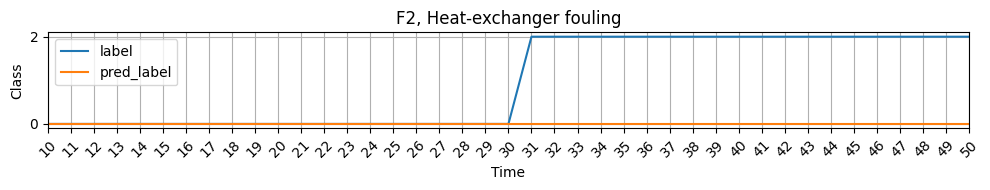

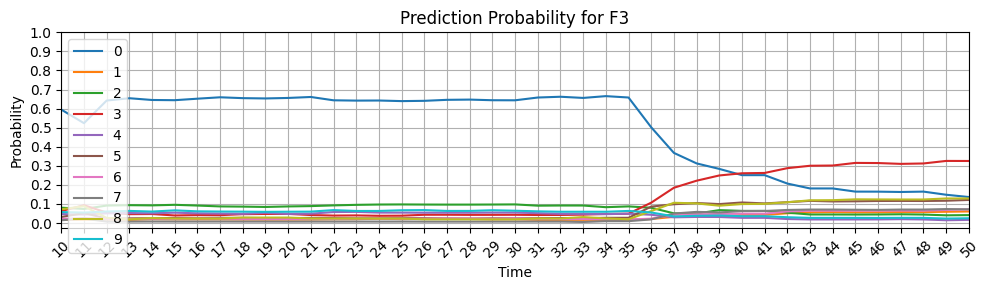

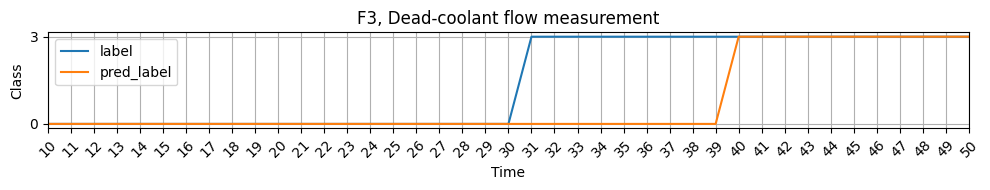

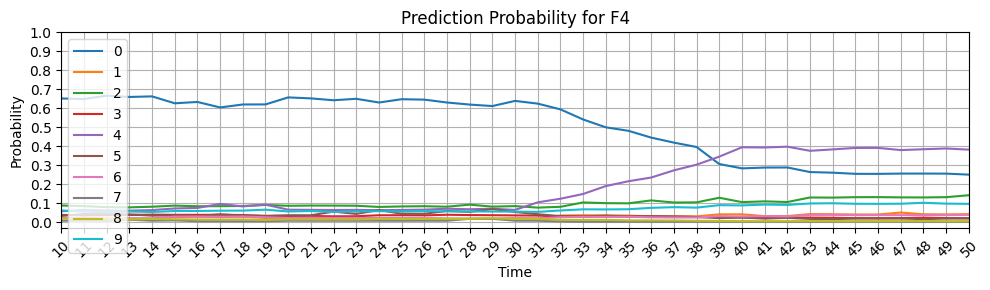

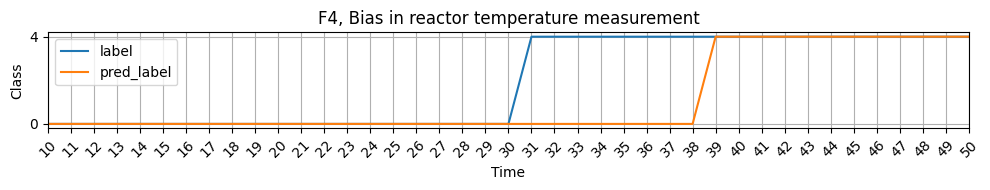

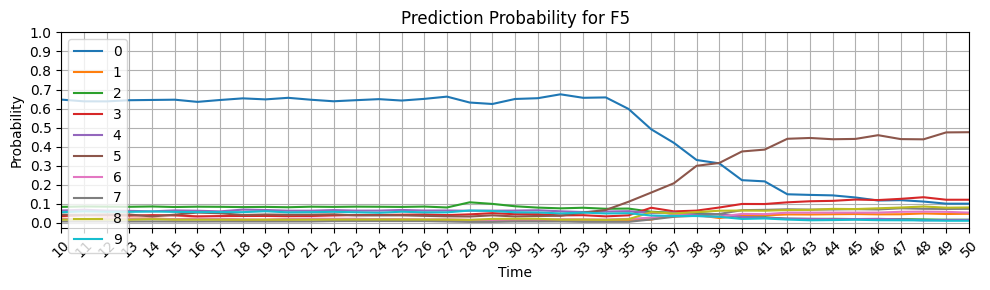

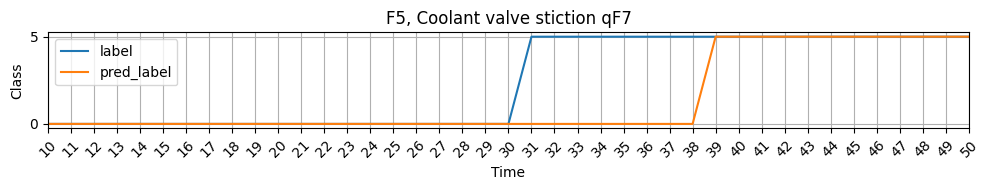

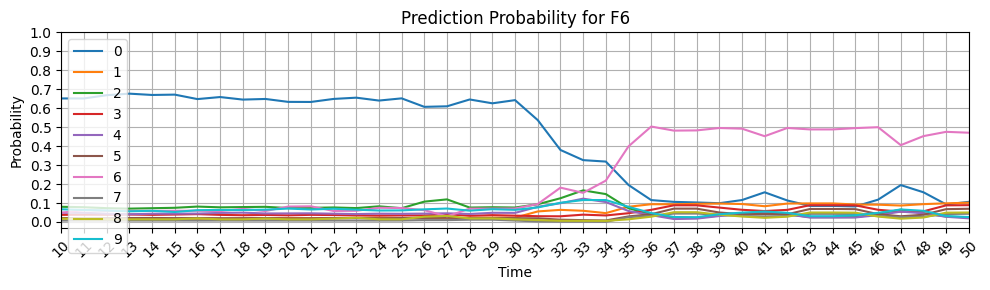

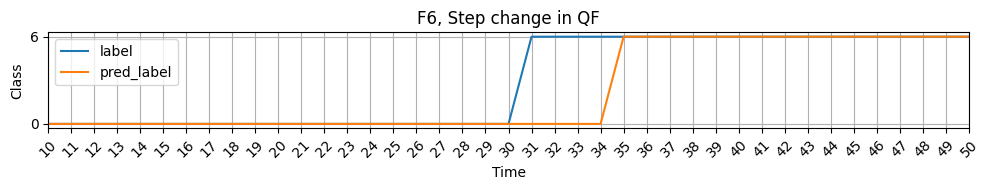

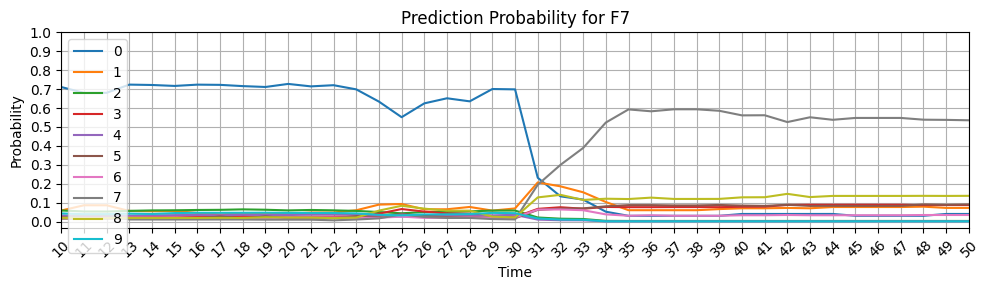

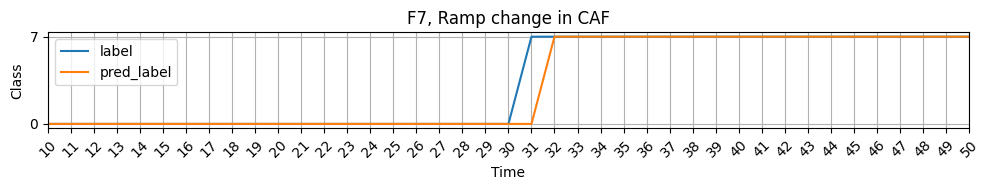

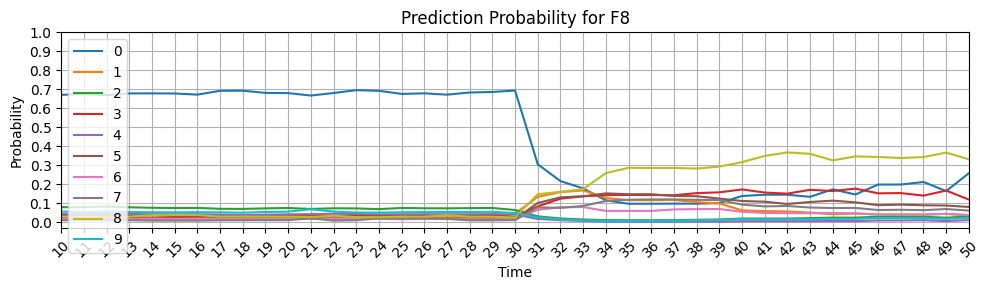

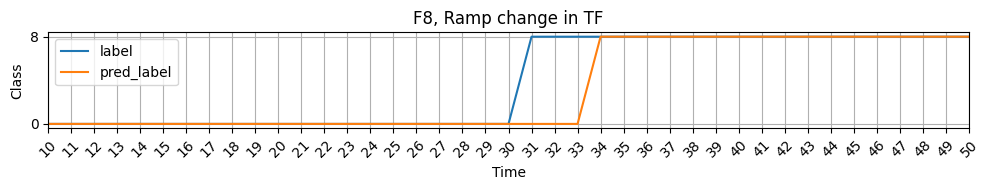

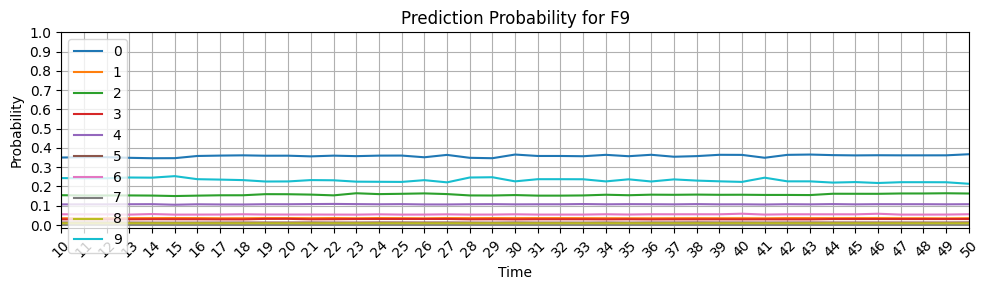

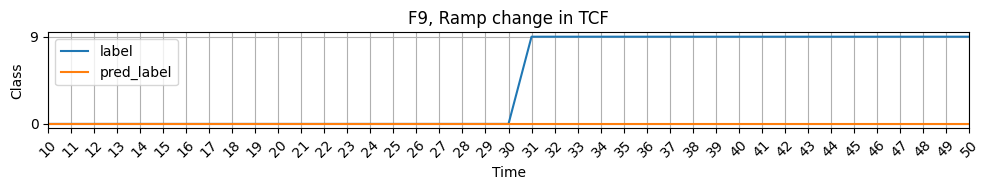

In [103]:
comparison_df=pd.DataFrame(test_labels)
comparison_df['pred_label'] = preds
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

warnings.filterwarnings("ignore")

for i in range(1,10):
    # print(comparison_df)
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()

    # print(single_node_df)
    # plt.figure(figsize=(20, 2))


# Plot prediction probability
    pred_ar = []
    for j in range(WINDOW_SIZE,100):
        loca = "node_{}_{}".format(i,j)
        predi = pipeline.predict_proba(test_timeseries.loc[[loca], :, :])
        pred_ar.append(predi[0])
    pred_df = pd.DataFrame(pred_ar, index=range(WINDOW_SIZE,100))
    # print(pred_df)

    pred_df.plot(figsize=(10, 3))
    plt.title("Prediction Probability for F{}".format(i))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()


    single_node_df.plot(figsize=(10, 2))

    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Class')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, i+1, step=i))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()

warnings.resetwarnings()


In [104]:
comte = explainers.BruteForceSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [105]:
test_labels['label']

node_id    timestamp
node_1_10  0            0
node_1_11  0            0
node_1_12  0            0
node_1_13  0            0
node_1_14  0            0
                       ..
node_9_95  0            9
node_9_96  0            9
node_9_97  0            9
node_9_98  0            9
node_9_99  0            9
Name: label, Length: 855, dtype: int64

In [106]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 1 #UPDATE HERE FOR OTHER CLASSES
pred_select = 0 #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_1_31', 21]]


In [80]:
# pipeline.predict_proba(test_timeseries.loc[['node_6_32'], :, :])

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected


array([[0.30897347, 0.04645388, 0.17725278, 0.01976333, 0.08574735,
        0.00446133, 0.26393131, 0.00088471, 0.00845797, 0.08407388]])

/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected
2024-03-06 20:17:11,770 INFO    Working on turning label from 0 to 1
2024-03-06 20:17:11,771 INFO    Returning distractors ['node_1_43', 'node_1_78']
2024-03-06 20:17:11,772 INFO    Trying distractor 1 / 2


/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True)  # Population skewness
/Users/omkar/Projects/forks/CoMTE/utils.py:206: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt_val = kurtosis(col, fisher=True, bias=True)  # Fisher's definition, bias-corrected
2024-03-06 20:17:11,784 INFO    Current probas: [[0.33921984 0.18850402 0.0295666  0.07947863 0.01435808 0.06806315
  0.07056551 0.08881691 0.08905063 0.03237663]]
/Users/omkar/Projects/forks/CoMTE/utils.py:205: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew_val = skew(col, bias=True

###########
['Qf', 'Tc']
###########


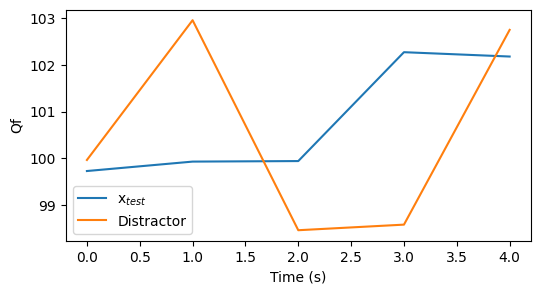

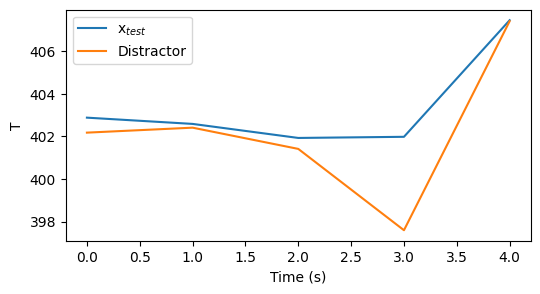

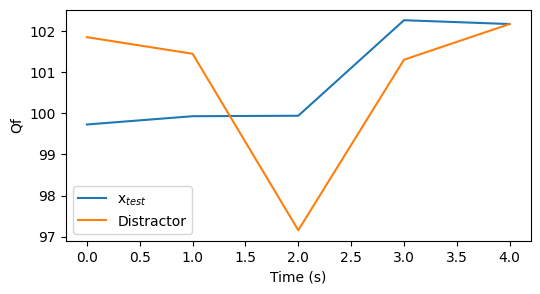

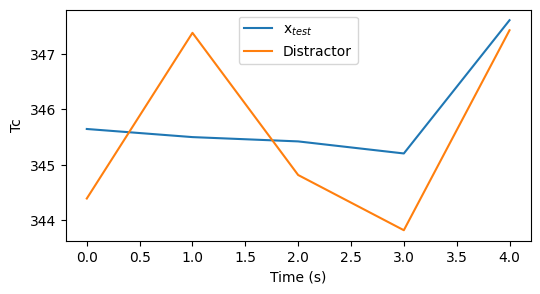

In [108]:
x_test = test_timeseries.loc[['node_1_31'], :, :]
explanation = comte.explain(x_test,to_maximize=true_select,savefig=False) 
print('###########') 
print(explanation)
print('###########')